In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn import metrics
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [27]:
#path = "/Users/zachgarberman/Desktop/Applied ML/Project Data/"
path = "/Users/pierre/Documents/Scolaire/MIT/Machine Learning/data/"
df = pd.read_csv(path + 'chicago_df.csv')

In [28]:
df_lin = df.copy()
df_lin['temperature'] = df_lin['temperature'] - 273.15
df_lin['hour_sq'] = df_lin['hour']**2
df_lin['hour_cub'] = df_lin['hour']**3
df_lin['hour_fourth'] = df_lin['hour']**4
df_lin['temperature_sq'] = df_lin['temperature']**2
df_lin['temperature_cub'] = df_lin['temperature']**3

One-Hot Encode, Test/Train Split

In [29]:
description_oh = pd.get_dummies(df_lin['description'], drop_first = True)
weekday_oh = pd.get_dummies(df_lin['dayofweek'], drop_first = True)
month_oh = pd.get_dummies(df_lin['month'], drop_first = True, prefix="Month")
df_2 = pd.concat([df_lin,description_oh,weekday_oh,month_oh],axis = 1)
df_2 = df_2.drop(['description','dayofweek','month'],axis=1)

In [30]:
X = df_2.iloc[:,2:]
y = df_2.iloc[:,0:1]

In [31]:
X_train = X.iloc[0:int(0.70*len(X)),]
y_train = y.iloc[0:int(0.70*len(X)),]
X_test = X.iloc[int(0.70*len(X)):,]
y_test = y.iloc[int(0.70*len(X)):,]

In [32]:
cols = X_train.columns

In [33]:
#X_train.to_csv(r'/Users/zachgarberman/Desktop/Applied ML/Project Data/Xtrain.csv', index = False)
#y_train.to_csv(r'/Users/zachgarberman/Desktop/Applied ML/Project Data/ytrain.csv', index = False)
#X_test.to_csv(r'/Users/zachgarberman/Desktop/Applied ML/Project Data/Xtest.csv', index = False)
#y_test.to_csv(r'/Users/zachgarberman/Desktop/Applied ML/Project Data/ytest.csv', index = False)

Linear Regression

In [34]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [35]:
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = reg.predict(X_test).reshape((m1,n1))
y_train_pred = reg.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.818618626331664
OS-R^2: 0.8057756952280277
OS-R^2: 0.8539488972842643
IS-MAE: 658.610134747542
OS-MAE: 704.1248464415561
IS-RMSE: 882.8923827171346
OS-RMSE: 938.1276042710257


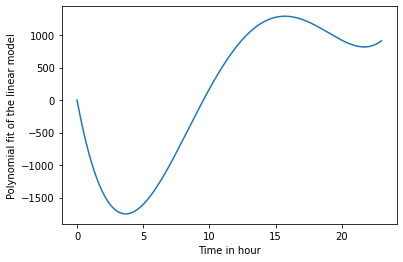

In [151]:
#coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
coefficients = dict(zip(X_train.columns, np.transpose(reg.coef_[0])))
c1, c2, c3, c4 = coefficients['hour'], coefficients['hour_sq'], coefficients['hour_cub'], coefficients['hour_fourth']
t = np.linspace(0, 23, 200)
plt.figure()
plt.plot(t, c1*t + c2*t**2 + c3*t**3 + c4*t**4)
plt.xlabel("Time in hour")
plt.ylabel("Polynomial fit of the linear model")
plt.show()

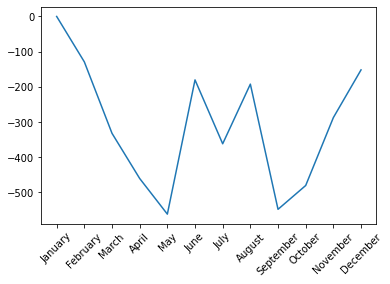

In [152]:
coef_month = [0]
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i in range(2,13):
    name = 'Month_' + str(i)
    coef_month += [coefficients[name]]
coef_month = np.array(coef_month)
plt.figure()
plt.plot(month, coef_month)
plt.xticks(rotation=45)
plt.show()

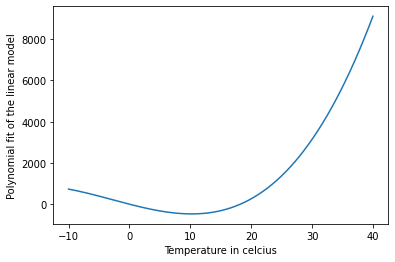

In [153]:
ctemperature1, ctemperature2, ctemperature3 = coefficients['temperature'], coefficients['temperature_sq'], coefficients['temperature_cub']
t = np.linspace(-10, 40, 200)
plt.figure()
plt.plot(t, ctemperature1*t + ctemperature2*t**2 + ctemperature3*t**3)
plt.xlabel("Temperature in celcius")
plt.ylabel("Polynomial fit of the linear model")
plt.show()

Cross-Validated Ridge Regression

In [154]:
scaler = StandardScaler()
scaler.fit(X_train)
ridge_train = pd.DataFrame(scaler.transform(X_train))
ridge_test = pd.DataFrame(scaler.transform(X_test))

In [155]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(ridge_train):
    X_tr, X_val = ridge_train.iloc[tr_index,:], ridge_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for penalty in [10,5,2,1,0.1,0.01,0.001,0]:
        ridge = Ridge(alpha=penalty)
        ridge.fit(X_tr, y_tr)
        m,n = y_val.shape
        y_val_pred = ridge.predict(X_val).reshape((m,n))
        SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
        train_mean = np.mean(y_tr.to_numpy())
        SST = np.sum((train_mean - y_val_pred)**2)
        OSR2 = 1 - (SSR/SST)
        score.append([i,
                      penalty,
                      OSR2])
    i += 1

In [156]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Lambda",2:"OSR2"})
cross_val = score.groupby(['Lambda']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

   Lambda      OSR2
1   0.001  0.707209


In [176]:
ridge_cv = Ridge(alpha=0.001).fit(ridge_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = ridge_cv.predict(ridge_test).reshape((m1,n1))
y_train_pred = ridge_cv.predict(ridge_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.8186186086627556
OS-R^2: 0.8057618698237337
IS-MAE: 658.6119808833638
OS-MAE: 704.1308311039571
IS-RMSE: 882.8924257197426
OS-RMSE: 938.1354247056337


Cross-Validated CART

In [158]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for md in [2,4,6,8,10]:
        for mb in [100,150,200]:
            for alpha in [100,10,1,0.1]:
                cart = DecisionTreeRegressor(
                    max_depth=md,
                    min_samples_leaf=mb,
                    criterion = "mse",
                    ccp_alpha = alpha)
                cart.fit(X_tr, y_tr)
                m,n = y_val.shape
                y_val_pred = cart.predict(X_val).reshape((m,n))
                SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                train_mean = np.mean(y_tr.to_numpy())
                SST = np.sum((train_mean - y_val_pred)**2)
                OSR2 = 1 - (SSR/SST)
                score.append([i,
                            md,
                            mb,
                            alpha, 
                            OSR2])
    i += 1

In [159]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Depth",2:"MinBucket", 3:"Alpha", 4:"OSR2"})
cross_val = score.groupby(['Depth','Alpha','MinBucket']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    Depth  Alpha  MinBucket      OSR2
48     10    0.1        100  0.513164
51     10    1.0        100  0.513164
54     10   10.0        100  0.513164


In [177]:
cart_cv = DecisionTreeRegressor(max_depth=10,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = cart_cv.predict(X_test).reshape((m1,n1))
y_train_pred = cart_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.8515663456185867
OS-R^2: 0.800125317645711
IS-MAE: 546.9237345487588
OS-MAE: 686.9588986432983
IS-RMSE: 798.6888406018527
OS-RMSE: 1005.4444715635977


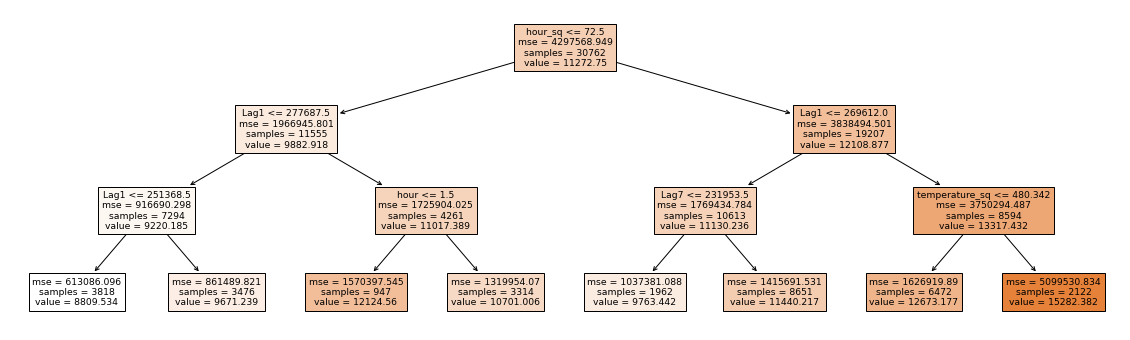

In [161]:
features = [i for i in X_test.columns]
cart_plot = DecisionTreeRegressor(max_depth=3,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
plt.figure(figsize=(20, 6))
tree.plot_tree(cart_plot, filled=True,feature_names=features)
plt.show()

Cross-Validated Gradient Boosted Trees

In [162]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for lr in [0.1,0.01,0.001]:
        for trees in [50,100,150]:
            for md in [3,5,7]:
                for features in ["auto","sqrt","log2"]:
                    gbm = GradientBoostingRegressor(
                        learning_rate=lr,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    gbm.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = gbm.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                lr,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [163]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "LearningRate",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['LearningRate','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    LearningRate  Trees  Depth Features    OSR2
73           0.1    150      3     log2  0.6819


In [178]:
gbm_cv = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=5, 
                                max_features='sqrt').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = gbm_cv.predict(X_test).reshape((m1,n1))
y_train_pred = gbm_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.9496515825270001
OS-R^2: 0.8927420029078388
IS-MAE: 324.06724447514944
OS-MAE: 485.1018481962171
IS-RMSE: 465.16211752332026
OS-RMSE: 724.9269470055522


In [108]:
best_model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=5, 
                                max_features='sqrt').fit(X_train, np.ravel(y_train))

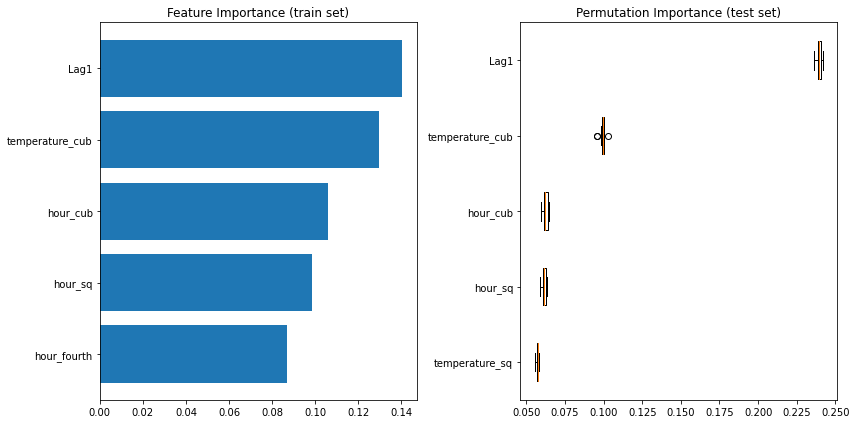

In [171]:
feature_importance = gbm_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[63:69]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(gbm_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[63:69]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Cross-Validated Random Forest

In [169]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for mb in [100,150,200]:
        for trees in [50,100,150]:
            for md in [2,4,6,8,10]:
                for features in ["auto","sqrt","log2"]:
                    rf = RandomForestRegressor(
                        min_samples_leaf=mb,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    rf.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = rf.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                mb,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [172]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "MinBucket",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['MinBucket','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    MinBucket  Trees  Depth Features      OSR2
12        100     50     10     auto  0.472685


In [173]:
rf_cv = RandomForestRegressor(min_samples_leaf=100, n_estimators=50, max_depth=10, 
                                max_features='auto').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = rf_cv.predict(X_test).reshape((m1,n1))
y_train_pred = rf_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.857115972853924
OS-R^2: 0.8193825172228784
IS-MAE: 535.0027625659613
OS-MAE: 646.4334430764698
IS-RMSE: 783.6159508427008
OS-RMSE: 930.3590951086394


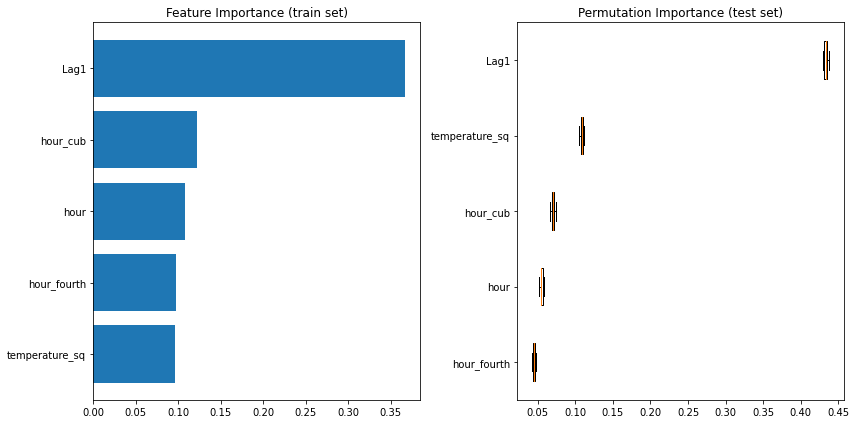

In [174]:
feature_importance = rf_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[63:69]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(rf_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[63:69]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Add Gaussian Noise

In [74]:
X = df_2.iloc[:,2:]
y = df_2.iloc[:,0:1]
m1,n1 = y_test.shape
m2,n2 = y_train.shape

def OSR2_lin(y_train_noise):
    reg = LinearRegression()
    reg.fit(X_train,y_train_noise)
    y_test_pred = reg.predict(X_test).reshape((m1,n1))
    y_train_pred = reg.predict(X_train).reshape((m2,n2))
    SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
    train_mean = np.mean(y_train.to_numpy())
    SST = np.sum((train_mean - y_test_pred)**2)
    OSR2 = 1 - (SSR/SST)
    return OSR2

def OSR2_cart(y_train_noise):
    cart_cv = DecisionTreeRegressor(max_depth=10,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train_noise)
    y_test_pred = cart_cv.predict(X_test).reshape((m1,n1))
    y_train_pred = cart_cv.predict(X_train).reshape((m2,n2))
    SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
    train_mean = np.mean(y_train.to_numpy())
    SST = np.sum((train_mean - y_test_pred)**2)
    OSR2 = 1 - (SSR/SST)
    return OSR2

def OSR2_boost(y_train_noise):
    gbm_cv = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=5, 
                                max_features='sqrt').fit(X_train, np.ravel(y_train_noise))
    y_test_pred = gbm_cv.predict(X_test).reshape((m1,n1))
    y_train_pred = gbm_cv.predict(X_train).reshape((m2,n2))
    SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
    train_mean = np.mean(y_train.to_numpy())
    SST = np.sum((train_mean - y_test_pred)**2)
    OSR2 = 1 - (SSR/SST)
    return OSR2


mean_energy = y.mean()[0]
len_energy = len(y.iloc[0:int(0.70*len(X)),])
OSR2_results = []
noise_amplitude_list = np.linspace(0.01,1,10)
bootstrap_length = 50
for noise_amplitude in noise_amplitude_list:
    OSR2_current_lin = np.zeros(bootstrap_length)
    OSR2_current_cart = np.zeros(bootstrap_length)
    OSR2_current_boost = np.zeros(bootstrap_length)
    for bootstrap_it in range(bootstrap_length):
        print(noise_amplitude, bootstrap_it)
        y_train_noise = np.array(y.iloc[0:int(0.70*len(X)),])[:,0] + np.random.normal(0, noise_amplitude*mean_energy,len_energy)
        OSR2_current_lin[bootstrap_it] = OSR2_lin(y_train_noise)
        OSR2_current_cart[bootstrap_it] = OSR2_cart(y_train_noise)
        OSR2_current_boost[bootstrap_it] = OSR2_boost(y_train_noise)
    print(OSR2_current_lin, OSR2_current_cart, OSR2_current_boost)
    OSR2_results += [[noise_amplitude, OSR2_current_lin.mean(), OSR2_current_lin.std(), OSR2_current_cart.mean(), OSR2_current_cart.std(), OSR2_current_boost.mean(), OSR2_current_boost.std()]]
df_OSR2_results = pd.DataFrame(OSR2_results, columns = ['noise_amplitude', 'R2_mean_lin', 'R2_std_lin', 'R2_mean_cart', 'R2_std_cart', 'R2_mean_boost', 'R2_std_boost'])
#df_OSR2_results

0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.01 11
0.01 12
0.01 13
0.01 14
0.01 15
0.01 16
0.01 17
0.01 18
0.01 19
0.01 20
0.01 21
0.01 22
0.01 23
0.01 24
0.01 25
0.01 26
0.01 27
0.01 28
0.01 29
0.01 30
0.01 31
0.01 32
0.01 33
0.01 34
0.01 35
0.01 36
0.01 37
0.01 38
0.01 39
0.01 40
0.01 41
0.01 42
0.01 43
0.01 44
0.01 45
0.01 46
0.01 47
0.01 48
0.01 49
[0.87022723 0.87021095 0.87000495 0.87031465 0.87013113 0.87014478
 0.87016075 0.87016388 0.87045375 0.87018229 0.87021434 0.87019948
 0.87006552 0.87024823 0.87025066 0.87004395 0.87019311 0.87048188
 0.86996555 0.87039595 0.87046232 0.87019353 0.87034637 0.87034517
 0.87026643 0.8702891  0.87026851 0.87013422 0.87004635 0.87026064
 0.87034594 0.87031664 0.86983902 0.87019589 0.87026624 0.86985817
 0.86999739 0.87007433 0.87001259 0.87031642 0.87012467 0.87020824
 0.87011625 0.87022321 0.87033167 0.87017973 0.86991163 0.87020972
 0.87025195 0.87018728] [0.8207888  0.82010231 0.82607898 0.82581004 0.817

0.45 1
0.45 2
0.45 3
0.45 4
0.45 5
0.45 6
0.45 7
0.45 8
0.45 9
0.45 10
0.45 11
0.45 12
0.45 13
0.45 14
0.45 15
0.45 16
0.45 17
0.45 18
0.45 19
0.45 20
0.45 21
0.45 22
0.45 23
0.45 24
0.45 25
0.45 26
0.45 27
0.45 28
0.45 29
0.45 30
0.45 31
0.45 32
0.45 33
0.45 34
0.45 35
0.45 36
0.45 37
0.45 38
0.45 39
0.45 40
0.45 41
0.45 42
0.45 43
0.45 44
0.45 45
0.45 46
0.45 47
0.45 48
0.45 49
[0.87048092 0.86877824 0.85007655 0.86547569 0.84540885 0.85037057
 0.86105311 0.86207764 0.85969156 0.85385212 0.86251714 0.86071977
 0.83981073 0.8624635  0.86312519 0.8693336  0.86292858 0.8415283
 0.8465154  0.86028732 0.85116743 0.86049094 0.84915404 0.85257684
 0.85852712 0.85509178 0.85839856 0.84366602 0.85453732 0.84532999
 0.85978549 0.85602591 0.85268158 0.84670859 0.84794638 0.85386745
 0.86455805 0.84400153 0.83655237 0.86141967 0.86147791 0.85653239
 0.86187872 0.85773078 0.85126091 0.8586436  0.87096484 0.86674342
 0.84249622 0.85077526] [0.69935643 0.7302286  0.69008409 0.68814558 0.66861855 0.

0.89 1
0.89 2
0.89 3
0.89 4
0.89 5
0.89 6
0.89 7
0.89 8
0.89 9
0.89 10
0.89 11
0.89 12
0.89 13
0.89 14
0.89 15
0.89 16
0.89 17
0.89 18
0.89 19
0.89 20
0.89 21
0.89 22
0.89 23
0.89 24
0.89 25
0.89 26
0.89 27
0.89 28
0.89 29
0.89 30
0.89 31
0.89 32
0.89 33
0.89 34
0.89 35
0.89 36
0.89 37
0.89 38
0.89 39
0.89 40
0.89 41
0.89 42
0.89 43
0.89 44
0.89 45
0.89 46
0.89 47
0.89 48
0.89 49
[0.84133978 0.76726654 0.79820569 0.81612774 0.84083735 0.75481911
 0.8265388  0.82090197 0.83422869 0.80823438 0.80528409 0.79187419
 0.73478    0.82035199 0.80967682 0.81826537 0.80970767 0.77967047
 0.8301766  0.81972279 0.83134755 0.82147298 0.81967297 0.79282933
 0.81718861 0.8275156  0.79847206 0.81245191 0.82968828 0.79950245
 0.78491971 0.8261642  0.84440473 0.83494983 0.79909645 0.81746651
 0.81074749 0.82311701 0.77459605 0.81445454 0.75209613 0.76462726
 0.81386504 0.84574592 0.82629526 0.80728808 0.82334694 0.80492608
 0.81886197 0.8169755 ] [0.50394214 0.45669348 0.51006937 0.51075207 0.42069853 0

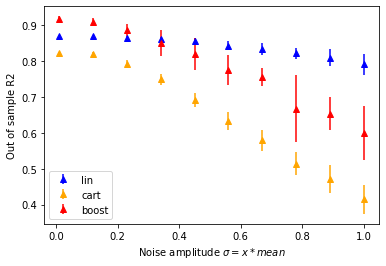

In [75]:
x = df_OSR2_results['noise_amplitude']
y_lin = df_OSR2_results['R2_mean_lin']
e_lin = df_OSR2_results['R2_std_lin']
y_cart = df_OSR2_results['R2_mean_cart']
e_cart = df_OSR2_results['R2_std_cart']
y_boost = df_OSR2_results['R2_mean_boost']
e_boost = df_OSR2_results['R2_std_boost']

plt.figure()
plt.errorbar(x, y_lin, e_lin, linestyle='None', marker='^', label = 'lin', color = 'blue')
plt.errorbar(x, y_cart, e_cart, linestyle='None', marker='^', label = 'cart', color = 'orange')
plt.errorbar(x, y_boost, e_boost, linestyle='None', marker='^', label = 'boost', color = 'red')
plt.legend()
plt.xlabel(r"Noise amplitude $\sigma = x*mean$")
plt.ylabel(r"Out of sample R2")
plt.savefig('figures/R2_bootstrap_methods.png', dpi = 300)
plt.show()

### Pittsburgh

In [37]:
df = pd.read_csv(path + 'pitt_df.csv')

In [38]:
df_lin = df.copy()
df_lin['temperature'] = df_lin['temperature'] - 273.15
df_lin['hour_sq'] = df_lin['hour']**2
df_lin['hour_cub'] = df_lin['hour']**3
df_lin['hour_fourth'] = df_lin['hour']**4
df_lin['temperature_sq'] = df_lin['temperature']**2
df_lin['temperature_cub'] = df_lin['temperature']**3

In [39]:
description_oh = pd.get_dummies(df_lin['description'], drop_first = True)
weekday_oh = pd.get_dummies(df_lin['dayofweek'], drop_first = True)
month_oh = pd.get_dummies(df_lin['month'], drop_first = True, prefix="Month")
df_2 = pd.concat([df_lin,description_oh,weekday_oh,month_oh],axis = 1)
df_2 = df_2.drop(['description','dayofweek','month'],axis=1)

In [40]:
X = df_2.iloc[:,2:]
X['proximity thunderstorm with drizzle'] = 0
X['smoke'] = 0
X['thunderstorm with drizzle']=0
X['thunderstorm with light drizzle']=0
X = X[cols]
y = df_2.iloc[:,0:1]
X_train = X.iloc[0:int(0.70*len(X)),]
y_train = y.iloc[0:int(0.70*len(X)),]
X_test = X.iloc[int(0.70*len(X)):,]
y_test = y.iloc[int(0.70*len(X)):,]

In [36]:
m1,n1 = y.shape
#y_pred = best_model.predict(X).reshape((m1,n1))
y_pred = reg.predict(X).reshape((m1,n1))
SSR = np.sum((y.to_numpy() - y_pred)**2)
train_mean = np.mean(y.to_numpy())
SST = np.sum((train_mean - y_pred)**2)
OSR2 = 1 - (SSR/SST)
print("OS-R^2:",OSR2)
print("OS-MAE:",metrics.mean_absolute_error(y,y_pred))
print("OS-RMSE:",metrics.mean_squared_error(y,y_pred)**(1/2))

OS-R^2: 0.7880950127179729
OS-MAE: 672.2654803612488
OS-RMSE: 899.8201776359691


In [41]:
reg = LinearRegression()
reg.fit(X_train,y_train)

m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = reg.predict(X_test).reshape((m1,n1))
y_train_pred = reg.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
# Why aren't we doing that? #####
print("OS-R^2:",metrics.r2_score(y_test.to_numpy(),y_test_pred))
########
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.855736323699557
OS-R^2: 0.8702371005504526
OS-R^2: 0.8886701713101157
IS-MAE: 83.65115365781816
OS-MAE: 81.86315539397697
IS-RMSE: 109.03576799440933
OS-RMSE: 106.16122283251153


In [165]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for lr in [0.1,0.01,0.001]:
        for trees in [50,100,150]:
            for md in [3,5,7]:
                for features in ["auto","sqrt","log2"]:
                    gbm = GradientBoostingRegressor(
                        learning_rate=lr,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    gbm.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = gbm.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                lr,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [166]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "MinBucket",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['MinBucket','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    MinBucket  Trees  Depth Features      OSR2
75        0.1    150      5     auto  0.777241


In [168]:
gbm_cv = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=5, 
                                max_features='auto').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = gbm_cv.predict(X_test).reshape((m1,n1))
y_train_pred = gbm_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-RMSE:",metrics.mean_squared_error(y_train,y_train_pred)**(1/2))
print("OS-RMSE:",metrics.mean_squared_error(y_test,y_test_pred)**(1/2))

IS-R^2: 0.9632678289705837
OS-R^2: 0.9242715293232688
IS-MAE: 40.583480572305724
OS-MAE: 59.25225689917018
IS-RMSE: 55.019138794203066
OS-RMSE: 82.35076204537934
